In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import seaborn as sns

path_original = "data/original"
path_cleaned = "data/cleaned"

# 0) Dataset clean-up

## Junk data

The datasets are organized into a number of .csv files. There appears to have been data leakage between the files. All files are affected. Some files contain 121 correct rows and over 494.000 incorrect rows.

#### Example

The file "regression_features_train.csv" contains data from a second dataset, namely,  "classification_targets_test". Problems being in the former dataset's row 159.386, which contains (a) junk text in the "year" column and (b) the original path to the latter dataset in the "month" column. The data between rows 159.387 and 162.928 mirrors the first few hundred rows in the second dataset. Leaked data from other files reapper all the way through to the former dataset's end.

In [2]:
regression_features_train = pd.read_csv(f"{path_original}/regression_features_train.csv", low_memory=False)

In [3]:
regression_features_train.loc[159386:159387]

,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,city
159386,PK�ą��-,NaN,month,day,city,rain,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159387,2014,1,1,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Automation

We attempted to automate the data clean-up. Our attempt assumed (apparently correctly) that all leaked data begins with the string "PK" in the "year" column. We would thus ignore all rows at and below the first row containing "PK", with the original datasets being preserved in a separate folder.

In [4]:
def dataset_cleanup(path_original, path_cleaned, filename):
    df = pd.read_csv(f"{path_original}/{filename}", low_memory=False, error_bad_lines=False)
    for index, row in df.iterrows():
        if str(row[0]).startswith("PK"):
            # As soon as we find "PK", we scrap the remaining rows.
            cleaned_df = df.head(row)
            cleaned_df.to_csv(f"{path_cleaned}/{filename}", index=False)
            break

#### Problem

However, pandas had great difficulty reading some of the CSV files, in the sense that it never finished parsing them. We hypothesized that it was due to memory issues, but using the "chunksize" argument in pd.read_csv(), producing a TextFileReader object that could _gradually_ read the .csv file, did not solve this issue. We do not know what causes this problem, but it is somehow related to the junk text we mentioned above.

#### Solution

We decided to manually clean up the data, a task we completed rather quickly using Excel to visualize and manipulate the .csv file.

## Mistaken data

We must now look to see if there are impossible values in our datasets. We looked at the most extreme values ever observed on Earth and set it as bounds for out data. China uses the metric system. Lacking information about the physics of dew points, we have chosen some arbitrary extreme values as bounds. The larger number of windspeeds above the observed maximum (372 kmph) made us adopt an upper bound of 1000 kmph to avoid cluttering the list below.

Lack of time prevented us from going through each dataset and removing from them each row containing mistaken data. We have looked below at mistakes in the training data for regression. Other datasets contain pressures over 10^6 hPa and temperatures well above 300°C. We hope that the test data contains a similar amount of errors (and of a similar kind) so as not to ruin our predictive ability.

In [5]:
reg_train_features = pd.read_csv(f"{path_cleaned}/regression_features_train.csv").dropna()
for index, row in reg_train_features.iterrows():
    try:
        dewpoint = float(row.DEWP)
        humidity = float(row.HUMI)
        pressure = float(row.PRES)
        temperature = float(row.TEMP)
        windspeed = float(row.Iws)
        rainfall = float(row.precipitation)
    except ValueError:
        print(f"Non-numeric data among these: {row.DEWP} (DEWP), {row.HUMI} (HUMI), {row.PRES} (PRES), {row.TEMP} (TEMP), {row.Iws} (Iws), {row.precipitation} (precipitation).")
    
    if dewpoint < -200 or dewpoint > 200:
        print(f"Anomalous dew point: {row.DEWP}°C at row {index}.")
    if humidity < 0 or humidity > 100:
        print(f"Anomalous humidity: {row.HUMI}% at row {index}.")
    if pressure < 870 or pressure > 1085:
        print(f"Anomalous pressure: {row.PRES} hPa at row {index}.")
    if temperature < -130 or temperature > 137:
        print(f"Anomalous temperature: {row.TEMP}°C at row {index}.")
    if windspeed < 0 or windspeed > 1000:
        print(f"Anomalous wind speed: {row.Iws} kmph at row {index}.")
    if rainfall < 0 or rainfall > 305:
        print(f"Anomalous rainfall: {row.precipitation} mm at row {index}.")

Anomalous dew point: -9999.0°C at row 102367.
Anomalous humidity: -9999.0% at row 102367.
Anomalous dew point: -9999.0°C at row 102368.
Anomalous humidity: -9999.0% at row 102368.
Anomalous dew point: -9999.0°C at row 102369.
Anomalous humidity: -9999.0% at row 102369.
Anomalous dew point: -9999.0°C at row 102370.
Anomalous humidity: -9999.0% at row 102370.
Anomalous wind speed: 1002.0 kmph at row 131791.
Anomalous wind speed: 1013.0 kmph at row 131792.
Anomalous wind speed: 1020.0 kmph at row 131793.
Anomalous wind speed: 1030.0 kmph at row 131794.
Anomalous wind speed: 1040.0 kmph at row 131795.
Anomalous wind speed: 1049.0 kmph at row 131796.
Anomalous wind speed: 1058.0 kmph at row 131797.
Anomalous wind speed: 1067.0 kmph at row 131798.
Anomalous wind speed: 1075.0 kmph at row 131799.
Anomalous wind speed: 1082.0 kmph at row 131800.
Anomalous wind speed: 1090.0 kmph at row 131801.
Anomalous wind speed: 1097.0 kmph at row 131802.
Anomalous wind speed: 1103.0 kmph at row 131803.
Ano

# 1) Data Analysis: Regression

## Data imports

In [6]:
reg_train_features = pd.read_csv(f"{path_cleaned}/regression_features_train.csv").dropna()
reg_train_targets = pd.read_csv(f"{path_cleaned}/regression_targets_train.csv").dropna()
reg_test_features = pd.read_csv(f"{path_cleaned}/regression_features_test.csv").dropna()
reg_test_targets = pd.read_csv(f"{path_cleaned}/regression_targets_test.csv").dropna()

### Such a long, multivariable dataset could be investigated in many dozen ways for underlying predictors.

* One could do separate analyses for different cities and different seasons.

* One could attempt to establish correlations between hourly features, or perhaps between monthly averages.

* One could even wonder whether occurrences at day D have lagged effects (say, on day D+3), thus looking for such lagged correlations.

### Here are a few strategies we ended up testing to predict monthly precipitation based on hourly correlation with atmospheric features.

An immediate idea is to perform a **(multi)linear regression** between hourly precipitation (p) and N hourly atmospheric features (x1 through xN), where the former is a linear function of the latter: p = β + α1·x1 + ··· + αN·xN, with constant β, α1, ···, αM. For instance, rainfall might be correlated with one feature (e.g., humidity), a few features (e.g. humidity and temperature), or a **composite feature** (e.g., "temperature is below dew point").

Python's scikit-learn makes this very easy with the class linear_model.LinearRegression, which can handle both linear and multilinear regression. LinearRegression can be fitted to a training dataset (.fit() method) and perform a set of predictions given a set of test data (.predict() method). One can then evaluate such predictions by evaluating the mean square distance between each test datum and its corresponding prediction with the metrics.mean_squared_error(test_data, predictions) function.

In addition, if there were such hourly correlations between precipitation and other things, one might perform a _Principal Component Analysis_ through pipelines easily constructed in Python using scikit-learn classes (preprocessing.StandardScaler for normalization — which assumes a roughly normally-distributed data, which may be reasonable for real-world climate data —, and decomposition.PCA for components and scree plot). By selecting the principal components that jointly explain above a certain threshold of data variation (say, 90%), one could perform a multilinear regression using those components as independent variables. This process is called _Principal Component Regression_.

#### Problem

The problem with this approach is that during most hours precipitation is nil. All atmospheric features undergo substantive variation while precipitation remains zero. This breaks down any attempt to establish a correlation between simple atmospheric features; their correlation is very low, as the cells below demonstrate. We will attempt a multilinear regression and a PCR anyway.

In [7]:
atmospheric_features = ["DEWP", "HUMI", "PRES", "TEMP", "Iws"]

In [8]:
print(f"Pearson correlation (R) between precipitation and...")
for feature in atmospheric_features:
    corr, _ = pearsonr(reg_train_features["precipitation"], reg_train_features[feature])
    print(f"\t{feature} = {corr:.5f}.")

Pearson correlation (R) between precipitation and...
	DEWP = 0.01853.
	HUMI = 0.04164.
	PRES = -0.08628.
	TEMP = 0.04620.
	Iws = 0.00021.


### Attempt 

We attempted a simple, unadjusted multilinear regression, but we found that its root mean squared error (RMSE) is nearly identical to the RMSE of an algorithm that predicts 0mm total rainfall for all months.

In the cell below, we fit a LinearRegression object to our data, performing a multilinear regression. We then perform hourly rainfall predictions (in mm) and append this to our reg_test_features database.

In [9]:
# Multilinear regression
regressor = LinearRegression()
regressor.fit(reg_train_features.loc[ : , atmospheric_features], reg_train_features.precipitation)

# Hourly predictions
y_pred_hourly = regressor.predict(reg_test_features.loc[ : , atmospheric_features])
reg_test_features['prediction'] = y_pred_hourly

We follow by convering the hourly predictions to summed monthly predictions, arranged in the same order as the "regression_targets_test.csv" file requires. Some hourly predictions were _negative_, and since that makes no physical sense we have ignored them.

In [10]:
def hours_to_months(df):
    # Creates a way to store city-year-month total rainfall (in mm)
    cities = [0, 1, 2, 3, 4]
    years = [2014, 2015]
    months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    dct_list = dict()
    for city in cities:
        dct_city = dict()
        for year in years:
            dct_year = dict()
            for month in months:
                dct_year[month] = 0
            dct_city[year] = dct_year
        dct_list[city] = dct_city
    
    # Adds city-year-month-hour predicted rainfall to a city-year-month total
    for index, row in df.iterrows():
        if row.prediction > 0:
            dct_list[row.city][row.year][row.month] += row.prediction
    
    # Creates a list of predicted monthly rainfall in the appropriate order
    y_pred = list()
    for city in cities:
        for month in months:
            for year in years:
                y_pred.append(dct_list[city][year][month])

    return y_pred

In [11]:
# Converts hourly predictions into monthly predictions
y_pred = hours_to_months(reg_test_features)
y_true = reg_test_targets.monthly_precipitation
len(y_pred) == len(y_true)

True

Although we have been able to perform monthly predictions, our model is no use. This is because our sanity-check "no-rain model" has an RMSE nearly identical to that of our regression model:

In [12]:
print(f"Multilinear regression's RMSE: {mean_squared_error(y_true, y_pred, squared=False):.2f}.")
print(f"No-rain model's RMSE: {mean_squared_error(y_true, [0] * len(y_true), squared=False):.2f}.")

Multilinear regression's RMSE: 91271.78.
No-rain model's RMSE: 91288.22.


### Principal Component Analysis

Since there is very low correlation between each atmospheric feature and precipitation, due to precipitation being zero 92% of the time, we expect that a PCA over atmospheric features would be unhelpful. Furthermore, since a multilinear regression employing all variables has given us little predictive power, a PCA is expected to give us even less predictive power.

Let us try anyway. As we can see below, three principal components (PCs) are enough to explain over 90% of the variance in the data. We can try to perform multilinear regression using these three PCs.

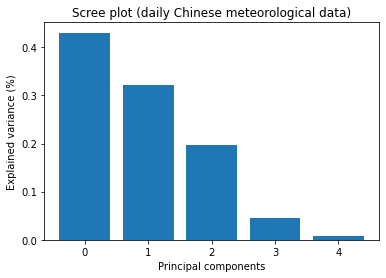

In [13]:
# Normalized data
reg_train_features_norm = StandardScaler().fit_transform(reg_train_features.loc[ : , atmospheric_features])

# Principal components decomposition
pca_model = PCA()
principal_components_train = pca_model.fit_transform(reg_train_features_norm)

# Graph
plt.bar(range(len(atmospheric_features)), pca_model.explained_variance_ratio_)
plt.xlabel("Principal components")
plt.ylabel("Explained variance (%)")
plt.title("Scree plot (daily Chinese meteorological data)")
plt.show()

We execute a multilinear regression over the training dataset. This amounts to a PCR (Principal Component Regression).

In [14]:
pc_train = pd.DataFrame(principal_components_train[ : , [0,  1, 2]])
regressor = LinearRegression()
regressor.fit(pc_train, reg_train_features.precipitation)

LinearRegression()

Now we perform predictions over the test dataset.

In [15]:
# Normalization
reg_test_features_norm = StandardScaler().fit_transform(reg_test_features.loc[ : , atmospheric_features])

# Principal component decomposition
principal_components_test = PCA().fit_transform(reg_test_features_norm)
pc_test = pd.DataFrame(principal_components_test[ : , [0,  1, 2]])

# Predicting
y_pred_hourly = regressor.predict(pc_test)
reg_test_features['prediction'] = y_pred_hourly

As in our previous example, we convert our hourly predictions into monthly predictions and compare them to the correct data, once again obtaining terrible results (as expected).

In [16]:
y_pred = hours_to_months(reg_test_features)
y_true = reg_test_targets.monthly_precipitation
print(f"Multilinear regression's RMSE: {mean_squared_error(y_true, y_pred, squared=False):.2f}.")
print(f"No-rain model's RMSE: {mean_squared_error(y_true, [0] * len(y_true), squared=False):.2f}.")

Multilinear regression's RMSE: 91272.15.
No-rain model's RMSE: 91288.22.


We end up with no idea on how to predict monthly rainfall.

# 2) Classification

# Data imports

In [17]:
cls_train_features = pd.read_csv(f"{path_cleaned}/classification_features_train.csv").dropna()
cls_train_targets = pd.read_csv(f"{path_cleaned}/classification_targets_train.csv").dropna()
cls_test_features = pd.read_csv(f"{path_cleaned}/classification_features_test.csv").dropna()
cls_test_targets = pd.read_csv(f"{path_cleaned}/classification_targets_test.csv").dropna()

## Deciding on an evaluation method. What do we want?

Classification algorithms are mainly evaluated relative to their true positive, true negative, false positive, and false negative ratios. The weight given to these different measures depend on what we prioritize.

When classifying patients as contaminated with COVID-19 or not, we strongly wish to avoid _false negatives_ (FNs), since an undetected infected patient (FN) is much worse than healthy patient misdetected as infected (FP). Therefore, we would choose **sensitivity or recall** (TP / TP+FN) to evaluate our classifier.

On the other hand, when classifying patients as eligible for invasive surgeries, we strongly wish to avoid _false positives_, since operating an uneligible patient (FP) could kill him, whereas an un-operated eligible patient (FN) could find alternative treatment. Therefore, we could choose **precision** (TP / TP+FP) instead — or, even, better, **specificity** (TN / TN+FP). The latter is better because we wish wish to maximize the detection of uneligible patients (TN) rather than the detection of eligible patients (TP).

In our case, we give qual weight to both measures: false positives and false negatives are equally undesirable. We therefore could evaluate our classifier using the **F1-score**: the harmonic mean of sensitivity and precision, and we choose a classifier whose parameters maximize the F1-score.

Alternatively, we could consider the _true positive rate_ (sensitivity, or TPR) relative to the _false positive rate_ (1 – specificity, or FPR), and construct what is called a _Receiver Operating Curve_ (ROC) by plotting TPR × FPR for different classifier parameters. We could even select a classifier by building a ROC for multiple classifiers and choosing the one with the greatest _Area Under the Curve_ (AUC).

The **problem** with the ROC-AUC proposal is that the dataset is **heavily imbalanced**: since it only rains 8% of the time, it is easy for a classifier to obtain a large number of true negatives, and a classifier that is very good in detecting _rain_ (positive) will not receive much weight. Specificity (and thus FPR) take true negatives into account and are skewed as a result, whereas precision (and thus F1-score) do not: they focus only on performance over positive cases.

We thus opt for a **Precision-Recall AUC** evaluation method. 

### Attempts

Since precipitation is often zero, perhaps it is best correlated with features which are also often zero. One idea is to consider a binary properties B, which either occur (B = 1) or fail to occur (B = 0). The idea is that rainfall would only occur (precipitation > 0) when B = 1. Binary properties can be obtained by constructing a _threshold feature_ T, which is such that T = 1 if and only if some value exceeds a threshold, and otherwise T = 0.

#### A. Temperature below dew point

One promising threshold property is the composite feature: "is the temperature below the dew point?" (TEMP < DEWP). My amateur **domain expertise** in rainfall suggests that there should be some correlation between rainfall and TEMP < DEWP, since to my knowledge that is the condition in which rainfall occurs.

#### Theoretical problem

However, TEMP < DEWP causes rainfall when it occurs at the high altitudes where there is cloud formation. However, **the data has been collected at surface-level**. So perhaps this composite feature is not a good predictor.

#### Testing

We can test this by forming a **confusion matrix**, with TEMP < DEWP as a predictor of whether there has been rainfall. A true positive would be the occurrence of TEMP < DEWP together with rainfall. A false negative would be rainfall occurring despite TEMP ≥ DEWP.

In [18]:
y_true = cls_train_features["precipitation"] > 0
y_pred = cls_train_features["TEMP"] < cls_train_features["DEWP"]
cmatrix = confusion_matrix(y_true, y_pred)
print(f"Rainfall occurs on {sum(y_true)} days out of {len(y_true)} days, a rate of {(sum(y_true) / len(y_true)) * 100:.2f}%.")
print(f"Surface-level temperature is below surface-level dew point on {sum(y_pred)} days out of {len(y_pred)} days, a rate of {(sum(y_pred) / len(y_pred)) * 100:.2f}%.")
print(f"This represents {cmatrix[1,1]} true positives, {cmatrix[0,0]} true negatives, {cmatrix[0,1]} false positives, and {cmatrix[1,0]} false negatives.")

Rainfall occurs on 12675 days out of 159382 days, a rate of 7.95%.
Surface-level temperature is below surface-level dew point on 2 days out of 159382 days, a rate of 0.00%.
This represents 0 true positives, 146705 true negatives, 2 false positives, and 12675 false negatives.


#### Results

Not a stellar performance. The high true negative rate is most likely due to the very low rainfall rate: a predictor that _always_ predicted non-rain would have almost exactly the same true negatives count! In fact, our predictor behaves almost exactly like this: TEMP < DEWP occurs only _twice_ in the whole dataset. We needn't even analyse its Precision-Recall Curve. Back to the drawing board.

#### B. Humidity above some threshold

Common sense would intuit that rainfall occurs when the atmosphere's relative humidity reaches 100%. Once again, this might be the case, but it is relevant only for the relative humidity at cloud-formation height. But we could guess that it rains more often when surface-level humidity is above some high threshold as well, such as 90%.

What we will do is **construct our own precision-recall curve** using different humidity levels as thresholds.

In [19]:
def get_precision_recall_point(y_true, series, threshold):
    y_pred = (series >= threshold)
    cmatrix = confusion_matrix(y_true, y_pred)
    TP = cmatrix[1,1]
    FP = cmatrix[0,1]
    precision = TP / (TP + FP)
    FN = cmatrix[1,0]
    recall = TP / (TP + FN)
    return precision, recall

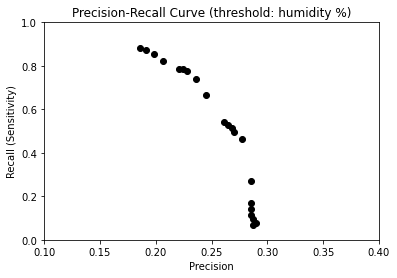

In [20]:
y_true = cls_train_features["precipitation"] > 0
humidity_series = cls_train_features["HUMI"]
for threshold in range(80, 101):
    precision, recall = get_precision_recall_point(y_true, humidity_series, threshold)
    plt.scatter(precision, recall, color='black')
plt.title("Precision-Recall Curve (threshold: humidity %)")
plt.xlabel("Precision")
plt.ylabel("Recall (Sensitivity)")
plt.xlim(0.1, 0.4)
plt.ylim(0, 1)
plt.show()

As one can see, precision is never above 30%, which means that using humidity to predict rainfall produces a large amount of false negatives: it is often quite humid without there being any rain.

# 3) Clustering
## Dataset import

In [21]:
clustering_dataset = pd.read_csv(f"{path_cleaned}/clustering_dataset.csv", low_memory=False)

## KMeans clustering and silhouette scoring

We will use the **KMeans iterative method** to generate k clusters. We begin by normalizing the data using StandardScaler, which assumes that our data is roughly normally distributed, which sounds reasonable for real-world average climate data. This assumption could be checked with one of various available **normality tests**, but time constraints have prevented us from doing so. We also apply a **PC analysis** to allow us to visualize our data in a 2D plot; there is support for 3D plots in Python but 2D plots are simpler. We then use the **silhouette score** as a means to evaluate our choice of k, which has ranged from k=2 to k=10. An alternative would have been the elbow method.

In [22]:
clustering_dataset_norm = StandardScaler().fit_transform(clustering_dataset.loc[ : , clustering_dataset.columns[2:]])
principal_components = PCA(n_components=2).fit_transform(clustering_dataset_norm)

<IPython.core.display.Javascript object>


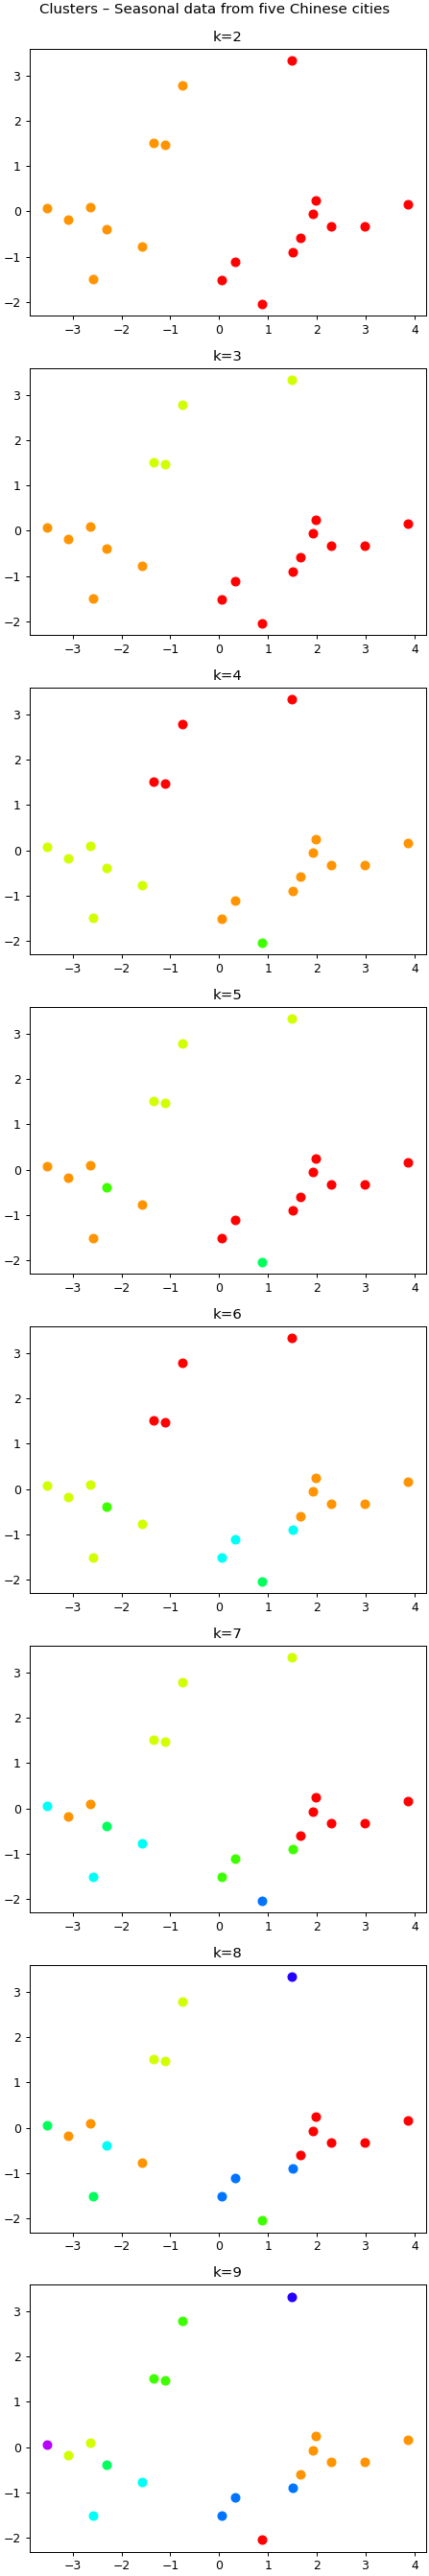

In [23]:
%matplotlib notebook

kmax = 10
fig, axs = plt.subplots(kmax-2, constrained_layout=True, figsize=(5,30))
fig.suptitle("Clusters – Seasonal data from five Chinese cities")

kmeans_dict = dict()
for k in range(2, kmax):
    colors = cm.hsv(np.linspace(0, 1, num=kmax + 1))
    kmeans_dict[f"kmeans{k}"] = KMeans(n_clusters=k, random_state=42).fit(clustering_dataset_norm)
    kmeans_dict[f"labels{k}"] = kmeans_dict[f"kmeans{k}"].labels_
    axs[k-2].set_title(f"k={k}")
    for index in range(len(clustering_dataset)):
        x = principal_components[index]
        axs[k-2].scatter(x[0], x[1], s=50, color=colors[kmeans_dict[f"labels{k}"][index]])

plt.show()

In [24]:
for k in range(2, kmax):
    score = silhouette_score(principal_components, kmeans_dict[f"labels{k}"])
    print(f"Silhouette coefficient for k={k} = {score}.")

Silhouette coefficient for k=2 = 0.5057792445926309.
Silhouette coefficient for k=3 = 0.5483811508342755.
Silhouette coefficient for k=4 = 0.33701098973731003.
Silhouette coefficient for k=5 = 0.0626417961215522.
Silhouette coefficient for k=6 = 0.12751192867257444.
Silhouette coefficient for k=7 = 0.14822836396423222.
Silhouette coefficient for k=8 = 0.1290077352895545.
Silhouette coefficient for k=9 = 0.19712159451698288.


As we can see, k=3 is preferable to any of the alternatives.